## Goal
Practice on data processing and know how-to use fastai's data block API

### About Dataset
German Traffic Sign Recognition Benchmark dataset is probably the most popular image classification related to self-driving cars. Autonomous vehicles need to detect and classify traffic signs to understand traffic rules applied to a segment of the road. Perhaps, this dataset is too small and incomplete to use it for real applications. Nevertheless, it is a good benchmark of computer vision algorithms.

#### From Kaggle
The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

Single-image, multi-class classification problem
More than 40 classes
More than 50,000 images in total
Large, lifelike database

In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
from fastai.vision import *

In [19]:
import csv
from collections import defaultdict, namedtuple

import os
import shutil

import numpy as np

### Getting the data

In [20]:
# create data folder
path = Config.data_path()/'gtsrb'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('C:/Users/Tim/.fastai/data/gtsrb')

In [21]:
# Download and unpack the training set and the test set
# The dataset has been moved here, https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html 

# ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -P {path}
# ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -P {path}
# ! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -P {path}
    
# ! unzip path/GTSRB_Final_Training_Images.zip -d {path}
# ! unzip path/GTSRB_Final_Test_Images.zip -d {path}
# ! unzip path/GTSRB_Final_Test_GT.zip -d {path}

In [22]:
# Download class names
# ! wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv -P {path}

In [23]:
Annotation = namedtuple('Annotation', ['filename', 'label'])
def read_annotations(filename):
    annotations = []
    
    with open(filename) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header

        # loop over all images in current annotations file
        for row in reader:
            filename = row[0] # filename is in the 0th column
            label = int(row[7]) # label is in the 7th column
            annotations.append(Annotation(filename, label))
            
    return annotations

In [24]:
def load_training_annotations(source_path):
    annotations = []
    for c in range(0,43):
        filename = os.path.join(source_path, format(c, '05d'), 'GT-' + format(c, '05d') + '.csv')
        annotations.extend(read_annotations(filename))
    return annotations

def copy_files(label, filenames, source, destination, move=False):
    func = os.rename if move else shutil.copyfile
    
    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
        
    for filename in filenames:
        destination_path = os.path.join(label_path, filename)
        if not os.path.exists(destination_path):
            func(os.path.join(source, format(label, '05d'), filename), destination_path)

def split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction=0.2):
    """
    Splits the GTSRB training set into training and validation sets.
    """
    
    if not os.path.exists(train_path):
        os.makedirs(train_path)
        
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)
        
    if not os.path.exists(all_path):
        os.makedirs(all_path)
    
    annotations = load_training_annotations(source_path)
    filenames = defaultdict(list)
    for annotation in annotations:
        filenames[annotation.label].append(annotation.filename)

    for label, filenames in filenames.items():
        filenames = sorted(filenames)
        
        validation_size = int(len(filenames) // 30 * validation_fraction) * 30
        train_filenames = filenames[validation_size:]
        validation_filenames = filenames[:validation_size]
        
        copy_files(label, filenames, source_path, all_path, move=False)
        copy_files(label, train_filenames, source_path, train_path, move=True)
        copy_files(label, validation_filenames, source_path, validation_path, move=True)

In [25]:
source_path = path/'GTSRB/Final_Training/Images'
train_path = path/'train'
validation_path = path/'valid'
all_path = path/'all'
validation_fraction = 0.2
# split_train_validation_sets(source_path, train_path, validation_path, all_path, validation_fraction)

path.ls()

[WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/all'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/export.pkl'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/from_kaggle'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/ftest'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/ftest1'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GT-final_test.csv'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GT-final_testdev.csv'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge.zip'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Final_Test_GT.zip'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Final_Test_Images.zip'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Final_Training_Images.zip'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/models'),
 WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/signnames.csv'),
 WindowsPath('C:/Users/Tim/.fastai/data

In [26]:
test_path = path/'GT-final_test.csv'
test_annotations = read_annotations(test_path)

In [27]:
classes = pd.read_csv(path/'signnames.csv')

class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]

class_names

{'0': 'Speed limit (20km/h)',
 '1': 'Speed limit (30km/h)',
 '2': 'Speed limit (50km/h)',
 '3': 'Speed limit (60km/h)',
 '4': 'Speed limit (70km/h)',
 '5': 'Speed limit (80km/h)',
 '6': 'End of speed limit (80km/h)',
 '7': 'Speed limit (100km/h)',
 '8': 'Speed limit (120km/h)',
 '9': 'No passing',
 '10': 'No passing for vechiles over 3.5 metric tons',
 '11': 'Right-of-way at the next intersection',
 '12': 'Priority road',
 '13': 'Yield',
 '14': 'Stop',
 '15': 'No vechiles',
 '16': 'Vechiles over 3.5 metric tons prohibited',
 '17': 'No entry',
 '18': 'General caution',
 '19': 'Dangerous curve to the left',
 '20': 'Dangerous curve to the right',
 '21': 'Double curve',
 '22': 'Bumpy road',
 '23': 'Slippery road',
 '24': 'Road narrows on the right',
 '25': 'Road work',
 '26': 'Traffic signals',
 '27': 'Pedestrians',
 '28': 'Children crossing',
 '29': 'Bicycles crossing',
 '30': 'Beware of ice/snow',
 '31': 'Wild animals crossing',
 '32': 'End of all speed and passing limits',
 '33': 'Turn 

### build data bunch

In [28]:
bs = 160

# don't flip, flip won't help, sometimes flip a traffic sign changes the whole meaning. can allow some rotate, some warp(形变)

tfms = get_transforms(do_flip=False, max_lighting=0.2, max_zoom=1.2, max_rotate=20, max_warp=0.1)

In [29]:
src = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder())              #Optionally add a test set (here default name is test)


In [30]:
data = (src.transform(tfms, size=96)       #Data augmentation? -> use tfms with a size of 64
        .databunch(bs=bs))                   #Finally? -> use the defaults for conversion to ImageDataBunch

data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb

In [12]:
data.train_ds[0]

(Image (3, 96, 96), Category 0)

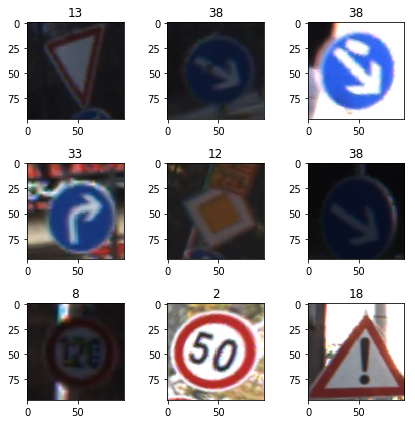

In [209]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [13]:
data.valid_ds.classes[:3]

['0', '1', '10']

### Build Model and Train
We will use the same model as the one used in Lesson3 planet for this multiclassification task.

In [31]:
arch = models.resnet34

# use deeper cnn on good GPU
# arch = models.resnet50

In [32]:
learn = cnn_learner(data, arch, metrics=[accuracy])
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


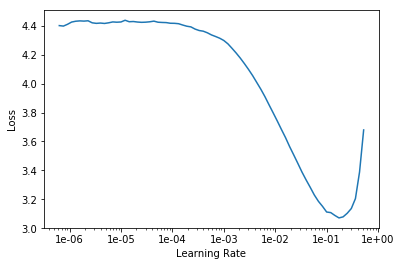

In [19]:
learn.recorder.plot()

In [30]:
lr = 0.01

In [31]:
learn.fit_one_cycle(4, slice(lr), wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,0.805741,0.802583,0.752675,04:12
1,0.252517,0.394216,0.884911,04:12
2,0.121867,0.275345,0.911660,04:16
3,0.074231,0.249876,0.924829,04:26


In [32]:
learn.save('stage-1-rn34-fp32-partds')

#### Stage II

In [17]:
learn.load('stage-1-rn34-fp32-partds')

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


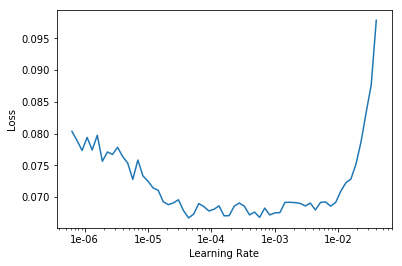

In [24]:
learn.lr_find()
learn.recorder.plot()

In [18]:
tfms = get_transforms(do_flip=False, max_lighting=0.1, max_zoom=1.2, max_rotate=20, max_warp=0.1)
data = (src.transform(tfms, size=128)
       .databunch(bs=100))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 128, 128])

In [19]:
learn.to_fp16()
#learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

In [19]:
learn.unfreeze()

In [20]:
lr = 3e-3
learn.fit_one_cycle(7, slice(lr), wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,0.062587,0.233024,0.932647,05:16
1,0.045876,0.126080,0.961317,05:27
2,0.036369,0.128136,0.968038,06:09
3,0.021299,0.058711,0.985460,05:37
4,0.012564,0.054052,0.989300,05:42
5,0.003338,0.030113,0.990809,05:36
6,0.001610,0.025094,0.993964,05:33


In [21]:
learn.save('stage-2-rn34-partds-112')

In [26]:
learn.load('stage-2-rn34-partds-112').to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


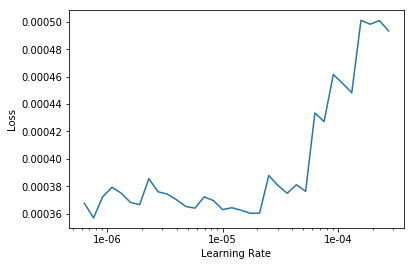

In [28]:
learn.lr_find()
learn.recorder.plot()

In [27]:
#learn.unfreeze()

lr = 1e-3
learn.fit_one_cycle(5, slice(lr), wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,0.005469,0.034898,0.990398,06:54
1,0.008085,0.018941,0.994239,07:07
2,0.005300,0.017992,0.995748,07:13
3,0.001488,0.013215,0.996982,07:14
4,0.000780,0.014075,0.996982,07:14


In [29]:
learn.save('stage-2b-rn34-partds-112')

In [31]:
learn.load('stage-2b-rn34-partds-112').to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (31919 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: C:\Users\Tim\.fastai\data\gtsrb;

Test: LabelList (12630 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

In [32]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5), wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,0.000624,0.012884,0.997257,07:47
1,0.000864,0.012056,0.997394,08:00
2,0.000474,0.011951,0.997257,08:06
3,0.000425,0.012131,0.997394,07:46
4,0.000444,0.012001,0.997394,07:28


In [35]:
learn.save('stage-2c-rn34-partds-112')

#### Plot top losses

In [33]:
learn.to_fp32()
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [23]:
len(y),y

(7290, tensor([ 0,  0,  0,  ..., 42, 42, 42]))

In [24]:
len(preds), preds

(7290,
 tensor([[9.9975e-01, 9.0796e-05, 1.9669e-07,  ..., 9.6609e-08, 3.6536e-06,
          4.7182e-07],
         [9.9988e-01, 4.1575e-05, 6.8917e-08,  ..., 4.2542e-08, 2.5114e-06,
          1.8552e-07],
         [9.9986e-01, 6.0964e-05, 7.9013e-08,  ..., 5.0816e-08, 1.4466e-06,
          1.8624e-07],
         ...,
         [5.0286e-06, 3.1136e-05, 8.2182e-06,  ..., 2.4121e-06, 1.2529e-06,
          9.9982e-01],
         [5.6399e-06, 4.0609e-05, 8.4664e-06,  ..., 2.8957e-06, 1.6663e-06,
          9.9980e-01],
         [5.7020e-06, 5.1634e-05, 1.0257e-05,  ..., 2.6816e-06, 1.1770e-06,
          9.9977e-01]]))

RuntimeError: expected scalar type Half but found Float

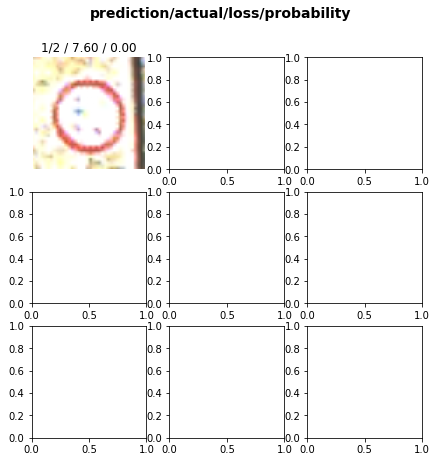

In [34]:
interp.plot_top_losses(9, figsize=(7,7))

### Stage III train with full dataset for Kaggle Test 

In [33]:
# for https://www.kaggle.com/c/acc-german-traffic-sign-classification/data, Use its data in subfolder
cpath =Config.data_path()/'gtsrb/GTSRB_Challenge'
cpath

WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge')

In [34]:
src = (ImageList.from_folder(cpath) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder())              #Optionally add a test set (here default name is test)


In [38]:
tfms = get_transforms(do_flip=False, max_lighting=0.2, max_zoom=1.2, max_rotate=20, max_warp=0.1)
data = (src.transform(tfms, size=112)
       .databunch(bs=100))

learn.data = data
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (39209 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
00000,00000,00000,00000,00000
Path: C:\Users\Tim\.fastai\data\gtsrb\GTSRB_Challenge;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
00000,00000,00000,00000,00000
Path: C:\Users\Tim\.fastai\data\gtsrb\GTSRB_Challenge;

Test: LabelList (12630 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb\GTSRB_Challenge, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kern

In [39]:
gc.collect()

182

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


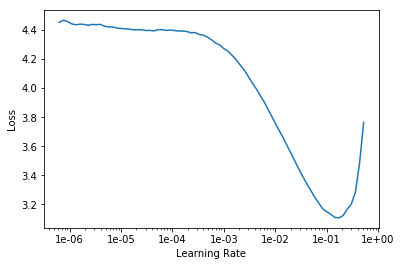

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.to_fp32()

Learner(data=ImageDataBunch;

Train: LabelList (39209 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
00000,00000,00000,00000,00000
Path: C:\Users\Tim\.fastai\data\gtsrb\GTSRB_Challenge;

Valid: LabelList (7290 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
00000,00000,00000,00000,00000
Path: C:\Users\Tim\.fastai\data\gtsrb\GTSRB_Challenge;

Test: LabelList (12630 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb\GTSRB_Challenge, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kern

In [42]:
learn.unfreeze()

lr = 1e-2
learn.fit_one_cycle(7, slice(lr), wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,0.142899,0.066914,0.984225,08:18
1,0.174196,0.378260,0.933333,08:19
2,0.079894,0.055033,0.983813,08:22
3,0.050924,0.027451,0.993004,08:13
4,0.022004,0.020383,0.996708,08:12
5,0.007916,0.000425,1.000000,08:08
6,0.002596,0.000189,1.000000,08:14


In [43]:
learn.save('stage-3-rn34-fullds-112')

## Export model 

In [44]:
learn.export(file='export-fullds.pkl')

## Kaggle Competition on GTSRB
https://www.kaggle.com/c/acc-german-traffic-sign-classification/data

$ kaggle competitions download -c acc-german-traffic-sign-classification

$ kaggle competitions submit -c acc-german-traffic-sign-classification -f submission.csv -m "fastai is aweseom, Tim@Shanghai"

In [45]:
cpath

WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge')

In [46]:
test_ds = ImageList.from_folder(cpath/'test')
len(test_ds)

12630

In [47]:
#learn = load_learner(path, test=test_ds)
learn.to_fp32()

#preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds,y,losses = learn.get_preds(ds_type=DatasetType.Test, with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [48]:
im,cl = interp.data.dl(interp.ds_type).dataset[0]
print(im, cl)

Image (3, 112, 112) 00000


In [45]:
# seems fastai has a bug here.. valid index is used for test dataset index
# IndexError: index 9083 is out of bounds for axis 0 with size 7290

#interp.ds_type = DatasetType.Valid
#im,cl = interp.data.dl(interp.ds_type).dataset[0]
#print(im, cl)

Image (3, 128, 128) 0


IndexError: index 11410 is out of bounds for axis 0 with size 7290

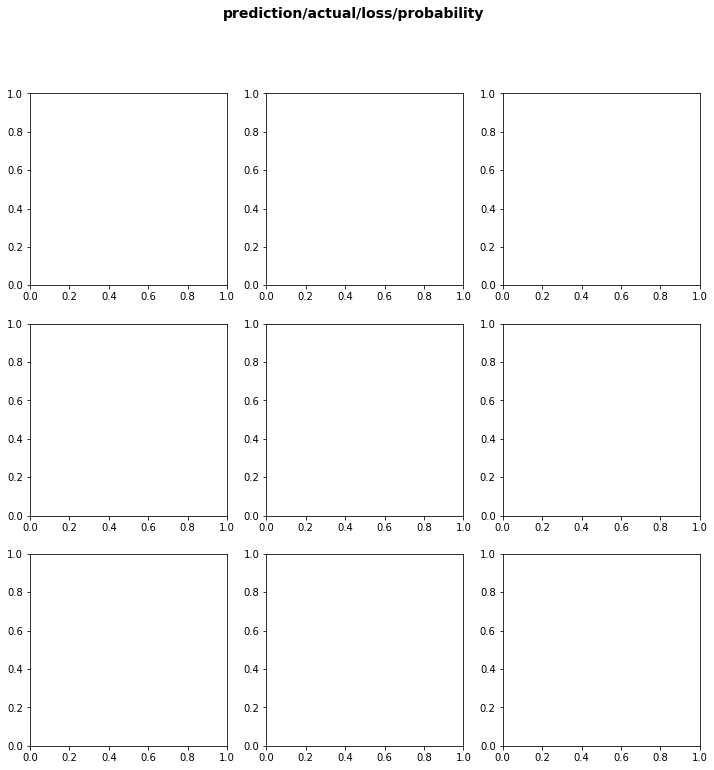

In [49]:
interp.plot_top_losses(9, figsize=(12,12))

In [52]:
test_ds.x[4]

TypeError: 'NoneType' object is not subscriptable

In [51]:
classes = learn.data.classes
classes[:3]

['00000', '00001', '00002']

In [53]:
learn.data.test_ds.items[:5]

array([WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge/test/1558973073.8358536.ppm'),
       WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge/test/1558973073.8359206.ppm'),
       WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge/test/1558973073.8359365.ppm'),
       WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge/test/1558973073.8359509.ppm'),
       WindowsPath('C:/Users/Tim/.fastai/data/gtsrb/GTSRB_Challenge/test/1558973073.8359642.ppm')], dtype=object)

In [54]:
preds

tensor([[1.3071e-08, 1.0247e-06, 9.2585e-07,  ..., 1.1107e-08, 1.2365e-06,
         1.7754e-06],
        [4.0425e-06, 9.9988e-01, 1.0788e-05,  ..., 1.3221e-06, 2.6208e-07,
         4.2886e-06],
        [1.2548e-07, 7.1026e-07, 1.9681e-06,  ..., 3.2229e-06, 1.0020e-06,
         1.7359e-07],
        ...,
        [5.1397e-05, 1.5678e-04, 5.6510e-05,  ..., 4.3111e-05, 1.0361e-04,
         1.5288e-04],
        [1.6661e-06, 3.6666e-05, 3.5413e-06,  ..., 2.4693e-05, 5.2724e-06,
         1.3920e-05],
        [1.0975e-06, 4.1705e-07, 5.3370e-07,  ..., 1.8249e-06, 2.0049e-07,
         4.1439e-06]])

In [55]:
print(classes[np.argmax(preds[10]).numpy()], classes[np.argmax(preds[33]).numpy()], classes[np.argmax(preds[38]).numpy()],
classes[np.argmax(preds[39]).numpy()], classes[np.argmax(preds[48]).numpy()], classes[np.argmax(preds[50]).numpy()],
     classes[np.argmax(preds[69]).numpy()], classes[np.argmax(preds[72]).numpy()], classes[np.argmax(preds[83]).numpy()])

00012 00023 00016 00008 00018 00018 00028 00011 00007


In [75]:
test_ds.x[50]

TypeError: 'NoneType' object is not subscriptable

In [76]:
test_ds.x[72]

TypeError: 'NoneType' object is not subscriptable

In [57]:
results = ["" for x in range(preds.shape[0])]
for i in np.arange(preds.shape[0]):
    results[i] = int(classes[np.argmax(preds[i]).numpy()])

results[:5]

[16, 1, 38, 33, 11]

In [58]:
ids = [item.name for item in learn.data.test_ds.items]
ids[:5]

['1558973073.8358536.ppm',
 '1558973073.8359206.ppm',
 '1558973073.8359365.ppm',
 '1558973073.8359509.ppm',
 '1558973073.8359642.ppm']

In [59]:
df = pd.DataFrame({'Filename':ids, 'ClassId':results}, columns=['Filename', 'ClassId'])
df.head()

,Filename,ClassId
0,1558973073.8358536.ppm,16
1,1558973073.8359206.ppm,1
2,1558973073.8359365.ppm,38
3,1558973073.8359509.ppm,33
4,1558973073.8359642.ppm,11


In [60]:
df.to_csv(path/'submission4.csv', index=False)

In [ ]:
# ! kaggle competitions submit -c acc-german-traffic-sign-classification -f submission.csv -m "fastai is aweseom, Tim@Shanghai"

### Test Time Augmentation
Test-time augmentation (TTA) often helps to boost accuracy a bit more. The trick is to create a few augmented versions of the input image, run prediction on each of them, and then average results. The intuition behind this is that the model might be wrong in classifying some images but changing the image a bit can help the model to classify it better. It is like if a human wants to classify an object and they look at it from different angles, change lighting a bit, moving it closer to the eyes, until they can find the best viewpoint that helps to recognize the object with the greatest confidence.

What does <b>beta and scale</b> means?
in fastai/vision/tta.py, the relevant codes are:

def _tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, scale:float=1.35) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    ...
            tfm = [*augm_tfm, zoom(scale=scale, **d), crop_pad(**d)]
    ...
    
def _TTA(learn:Learner, beta:float=0.4, scale:float=1.35, ds_type:DatasetType=DatasetType.Valid, with_loss:bool=False) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."    
    ...
        final_preds = preds*beta + avg_preds*(1-beta)
    ...

In [174]:
learn.to_fp32()
log_preds,y_tta, losses_tta = learn.TTA(beta=0.7, scale=1.6, ds_type=DatasetType.Test, with_loss=True)

In [175]:
len(log_preds), log_preds

(12630,
 tensor([[9.4748e-04, 8.3539e-03, 2.9592e-03,  ..., 1.0360e-03, 1.8753e-03,
          1.6034e-03],
         [5.7807e-03, 7.6885e-01, 4.7675e-03,  ..., 1.4863e-03, 1.7066e-03,
          4.3412e-03],
         [3.2367e-04, 4.6642e-04, 5.3254e-04,  ..., 6.2301e-03, 7.2492e-04,
          8.7133e-04],
         ...,
         [1.0473e-03, 1.8196e-03, 2.1119e-03,  ..., 1.7842e-03, 3.5043e-03,
          5.0668e-03],
         [2.1459e-03, 3.6813e-03, 1.1591e-03,  ..., 8.0936e-04, 1.3231e-03,
          1.7406e-03],
         [9.0238e-04, 6.5529e-04, 4.0796e-03,  ..., 5.9454e-04, 5.0493e-03,
          7.8619e-04]]))

In [176]:
interp_tta = ClassificationInterpretation(learn, log_preds, y_tta, losses_tta)
interp_tta.ds_type

<DatasetType.Valid: 2>

In [194]:
interp_tta.ds_type = DatasetType.Test
interp_tta.ds_type
interp_tta.data.dl(DatasetType.Test).dataset

LabelList (12630 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: EmptyLabelList
,,,,
Path: C:\Users\Tim\.fastai\data\gtsrb\GTSRB_Challenge

IndexError: index 9479 is out of bounds for axis 0 with size 7290

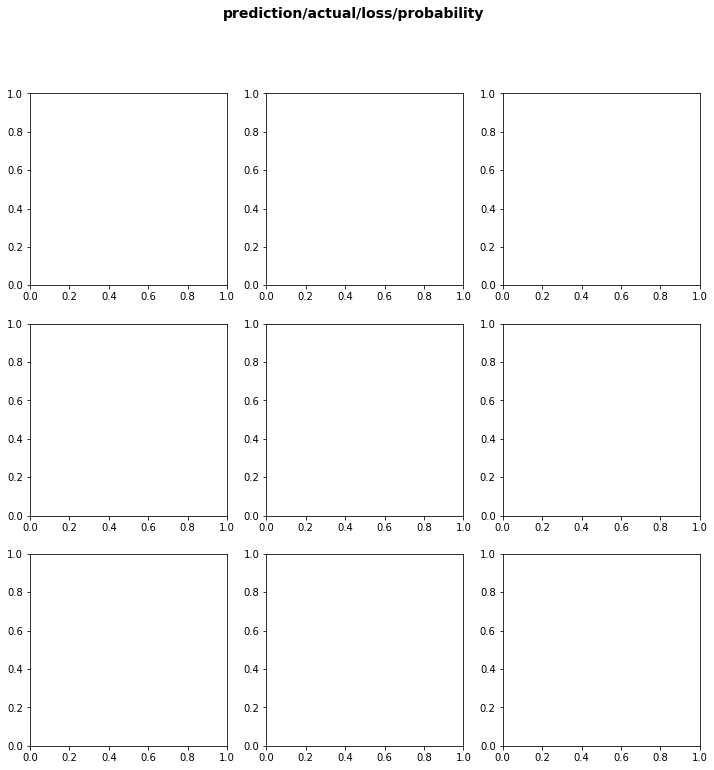

In [165]:
interp_tta.plot_top_losses(9, figsize=(12,12))

In [177]:
# check some prediction
np.argmax(log_preds[72]).numpy()

array(11, dtype=int64)

In [178]:
np.exp(log_preds[0])

tensor([1.0009, 1.0084, 1.0030, 1.0037, 1.0025, 1.0178, 1.0015, 1.0165, 1.0150,
        1.0018, 1.0120, 1.0177, 1.0035, 1.0401, 1.0033, 1.0101, 2.1144, 1.0132,
        1.0022, 1.0024, 1.0033, 1.0014, 1.0052, 1.0019, 1.0025, 1.0043, 1.0016,
        1.0011, 1.0011, 1.0072, 1.0209, 1.0031, 1.0020, 1.0020, 1.0017, 1.0009,
        1.0011, 1.0027, 1.0075, 1.0017, 1.0010, 1.0019, 1.0016])

In [179]:
preds_tta = np.exp(log_preds)
preds_tta

tensor([[1.0009, 1.0084, 1.0030,  ..., 1.0010, 1.0019, 1.0016],
        [1.0058, 2.1573, 1.0048,  ..., 1.0015, 1.0017, 1.0044],
        [1.0003, 1.0005, 1.0005,  ..., 1.0062, 1.0007, 1.0009],
        ...,
        [1.0010, 1.0018, 1.0021,  ..., 1.0018, 1.0035, 1.0051],
        [1.0021, 1.0037, 1.0012,  ..., 1.0008, 1.0013, 1.0017],
        [1.0009, 1.0007, 1.0041,  ..., 1.0006, 1.0051, 1.0008]])

In [180]:
int(np.argmax(preds_tta[0]).numpy())

16

In [181]:
results_tta = ["" for x in range(preds_tta.shape[0])]
for i in np.arange(preds_tta.shape[0]):
    results_tta[i] = np.argmax(preds_tta[i]).numpy()

results_tta[:3]

[array(16, dtype=int64), array(1, dtype=int64), array(38, dtype=int64)]

In [182]:
corrects_tta = 0

for i in np.arange(total):
    if(int(ftest_annots[i].label) == int(results_tta[i])):
        corrects_tta += 1

print('TTA Corrects:', corrects_tta, ' Accuracy:', corrects_tta/total)

TTA Corrects: 12540  Accuracy: 0.9928741092636579


In [183]:
df = pd.DataFrame({'Filename':ids, 'ClassId':results_tta}, columns=['Filename', 'ClassId'])
df.head()

,Filename,ClassId
0,1558973073.8358536.ppm,16
1,1558973073.8359206.ppm,1
2,1558973073.8359365.ppm,38
3,1558973073.8359509.ppm,33
4,1558973073.8359642.ppm,11


In [173]:
df.to_csv(path/'submission_tta.csv', index=False)

#### Error Analysis

In [154]:
class_names[str(int(results_tta[0]))]

'Vechiles over 3.5 metric tons prohibited'

In [156]:
for i in np.arange(total):
    if(int(ftest_annots[i].label) != int(results_tta[i])):
        print(i, '|', class_names[str(int(results_tta[i]))], '| Truth:', class_names[str(int(ftest_annots[i].label))])


50 | Double curve | Truth: Road work
176 | Speed limit (80km/h) | Truth: Speed limit (60km/h)
265 | Yield | Truth: Priority road
309 | Roundabout mandatory | Truth: Keep right
339 | Road work | Truth: Bumpy road
421 | Speed limit (50km/h) | Truth: Speed limit (70km/h)
492 | Speed limit (50km/h) | Truth: Speed limit (70km/h)
496 | Right-of-way at the next intersection | Truth: Beware of ice/snow
550 | Dangerous curve to the right | Truth: Speed limit (70km/h)
804 | No vechiles | Truth: Priority road
806 | Beware of ice/snow | Truth: Traffic signals
908 | No vechiles | Truth: Keep right
939 | No vechiles | Truth: Priority road
1234 | Speed limit (80km/h) | Truth: Speed limit (60km/h)
1270 | Speed limit (60km/h) | Truth: Speed limit (50km/h)
1477 | Turn left ahead | Truth: Ahead only
1489 | Yield | Truth: Priority road
1573 | Speed limit (80km/h) | Truth: Speed limit (60km/h)
1685 | Roundabout mandatory | Truth: Keep right
1781 | No vechiles | Truth: Keep right
1969 | Go straight or right

In [92]:
test_ds.x[908].size(96)

TypeError: 'NoneType' object is not subscriptable

## Check accuracy on the test dataset

In [61]:
path = Config.data_path()/'gtsrb'

In [62]:
ftest_file = path/'GT-final_test.csv'
ftest_annots = read_annotations(ftest_file)

In [67]:
ftest_annots[:3]

[Annotation(filename='00000.ppm', label=16),
 Annotation(filename='00001.ppm', label=1),
 Annotation(filename='00002.ppm', label=38)]

In [12]:
def copy_one_file(label, filename, source, destination, move=False):
    func = os.rename if move else shutil.copyfile
    
    label_path = os.path.join(destination, str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
        
    destination_path = os.path.join(label_path, filename)
    if not os.path.exists(destination_path):
        func(os.path.join(source, filename), destination_path)


In [64]:
total = len(ftest_annots)
total

12630

In [65]:
corrects = 0

for i in np.arange(total):
    if(int(ftest_annots[i].label) == int(results[i])):
        corrects += 1

print('Corrects:', corrects, ' Accuracy:', corrects/total)

Corrects: 12542  Accuracy: 0.9930324623911322


In [13]:
def process_final_test_ds(source_path, test_path):
    for filename, label in ftest_annots:
        copy_one_file(label, filename, source_path, test_path, move=False)

In [45]:
ftest_src = path/'ftest'
ftest_dest = path/'test'

process_final_test_ds(ftest_src, ftest_dest)